In [1]:
import json
import numpy as np
import pandas as pd
import torch
import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report

In [2]:
# Read all the data sets

set1_human = pd.read_json('dataset/set1_human.json')
set1_machine = pd.read_json('dataset/set1_machine.json')
set2_human = pd.read_json('dataset/set2_human.json')
set2_machine = pd.read_json('dataset/set2_machine.json')
set_test = pd.read_json('dataset/test.json')

# Add in label for all data sets
set1_human = set1_human.assign(label=1)
set2_human = set2_human.assign(label=1)
set1_machine = set1_machine.assign(label=0)
set2_machine = set2_machine.assign(label=0)

In [3]:
# Separate and concatenate into 2 sets, set 1 and set 2
set1 = pd.concat([set1_human, set1_machine])
set2 = pd.concat([set2_human, set2_machine])

# Split the labels and the data for training
x_set1 = pd.DataFrame(set1[['txt', 'prompt']])
y_set1 = pd.DataFrame(set1[['label']])
x_set2 = pd.DataFrame(set2[['txt', 'prompt']])
y_set2 = pd.DataFrame(set2[['label']])

In [4]:
x_set1['prompt_len'] = x_set1['prompt'].apply(lambda x: len(x))
x_set1['txt_len'] = x_set1['txt'].apply(lambda x: len(x))

x_set2['prompt_len'] = x_set2['prompt'].apply(lambda x: len(x))
x_set2['txt_len'] = x_set2['txt'].apply(lambda x: len(x))

set_test['prompt_len'] = set_test['prompt'].apply(lambda x: len(x))
set_test['txt_len'] = set_test['txt'].apply(lambda x: len(x))

In [5]:
#y_combined_set = pd.concat([y_set1, y_set2])

In [6]:
x_combined_set = x_set1

In [7]:
y_combined_set = y_set1

In [8]:
first_test = set_test[:600]

In [9]:
from gensim.models import Word2Vec

vocab = x_combined_set['txt'].tolist() + first_test['txt'].tolist()

model = Word2Vec(sentences=vocab, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [10]:
w2v_model =  gensim.models.Word2Vec.load("word2vec.model").wv

'''x_prompt = x_combined_set['prompt']

x_prompt_vec = []
for sentence in x_prompt:
    sentence_vec = []
    
    for word in sentence:
        sentence_vec.append(w2v_model[word])
    x_prompt_vec.append(np.mean(sentence_vec, axis=0))
x_prompt_vec = np.array(x_prompt_vec)'''

x_text = x_combined_set['txt']

x_text_vec = []
for sentence in x_text:
    sentence_vec = []
    
    for word in sentence[:300]:
        sentence_vec.append(w2v_model[word])
    x_text_vec.append(np.mean(sentence_vec, axis=0))
x_text_vec = np.array(x_text_vec)

'''prompt_len = np.expand_dims(x_combined_set['prompt_len'].values , axis=1)'''
txt_len = np.expand_dims(x_combined_set['txt_len'].values , axis=1)



In [11]:
x_set = np.concatenate((x_text_vec, txt_len), axis=1)

In [12]:
x_train, x_test, y_train, y_test= train_test_split(x_set, y_combined_set, test_size=0.1, stratify=y_combined_set)

In [13]:
from imblearn.over_sampling import RandomOverSampler

# define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
x_train_over, y_train_over = oversample.fit_resample(x_train, y_train)


In [14]:
x_train_set_1 = x_train
y_train_set_1 = y_train

In [15]:
lg_clf_1 = LogisticRegression(max_iter=1000)
lg_clf_1.fit(x_train, y_train)

y_pred = lg_clf_1.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.39      0.87      0.53       156
           1       1.00      0.98      0.99     12453

    accuracy                           0.98     12609
   macro avg       0.69      0.92      0.76     12609
weighted avg       0.99      0.98      0.98     12609



In [16]:
lg_clf_1 = LogisticRegression(max_iter=1000)
lg_clf_1.fit(x_train_over, y_train_over)

y_pred = lg_clf_1.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.92      0.17      0.29      1899
           1       0.87      1.00      0.93     10710

    accuracy                           0.87     12609
   macro avg       0.90      0.58      0.61     12609
weighted avg       0.88      0.87      0.83     12609



In [17]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 10,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42
}

lgb_clf_1 = lgb.LGBMClassifier(**params)
lgb_clf_1.fit(x_train_over, y_train_over)

y_pred = lgb_clf_1.predict(x_test)

print(classification_report(y_pred, y_test))

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046722 seconds.
You can set `force_col_wise=true` to remove the overhead.
              precision    recall  f1-score   support

           0       0.94      0.15      0.27      2125
           1       0.85     

In [18]:
'''test_prompt = first_test['prompt']
test_prompt_vec = []
for sentence in test_prompt:
    sentence_vec = []
    for word in sentence:
        if word in w2v_model:
            sentence_vec.append(w2v_model[word])
    if sentence_vec:
        test_prompt_vec.append(np.mean(sentence_vec, axis=0))
    else:
        test_prompt_vec.append(np.zeros_like(w2v_model[1479]))
test_prompt_vec = np.array(test_prompt_vec)
'''
test_text = first_test['txt']

test_text_vec = []
for sentence in test_text:
    sentence_vec = []
    
    for word in sentence[:200]:
        sentence_vec.append(w2v_model[word])
    test_text_vec.append(np.mean(sentence_vec, axis=0))
test_text_vec = np.array(test_text_vec)


'''test_prompt_len = np.expand_dims(first_test['prompt_len'].values , axis=1)'''
test_txt_len = np.expand_dims(first_test['txt_len'].values , axis=1)

test_vec = np.concatenate((test_text_vec, test_txt_len), axis=1)

In [19]:
first_pred = lg_clf_1.predict(test_vec)

In [20]:
first_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,

# Create model for set 2

In [21]:
x_set2# = pd.concat([x_set1[:400], x_set2])

,txt,prompt,prompt_len,txt_len
0,"[55, 1497, 3396, 3860, 85, 1624, 1486, 1525, 5...","[47, 2328, 1484, 1737, 36, 37, 4609, 1772, 157...",64,565
1,"[36, 2318, 42, 50, 51, 3717, 2493, 42, 72, 409...","[58, 36, 54, 43, 44, 49, 42, 55, 50, 49, 1737,...",78,1218
2,"[54, 1540, 1589, 1500, 44, 3882, 1705, 1478, 1...","[39, 82, 93, 1943, 1500, 1481, 2140, 2389, 147...",52,628
3,"[36, 86, 68, 3273, 1936, 15, 1479, 56, 17, 54,...","[1737, 51, 1489, 81, 54, 87, 1643, 56, 2462, 2...",59,1088
4,"[44, 87, 1515, 1479, 1510, 1564, 1480, 51, 148...","[1737, 51, 1647, 1705, 1480, 3486, 2318, 1500,...",72,732
...,...,...,...,...
395,"[55, 1497, 70, 1693, 2159, 1500, 51, 1481, 214...","[52, 88, 76, 1485, 15, 40, 2349, 1508, 1494, 1...",40,1168
396,"[55, 1497, 2949, 2660, 4578, 1589, 4644, 1568,...","[1737, 54, 76, 91, 38, 75, 1714, 1504, 38, 171...",70,713
397,"[44, 87, 10, 86, 1536, 4361, 2960, 2166, 3237,...","[58, 1984, 1488, 2298, 1737, 58, 3365, 1479, 2...",57,916
398,"[55, 75, 1480, 1977, 1533, 2351, 2929, 1495, 1...","[11, 48, 1490, 1539, 1747, 12, 1737, 39, 1514,...",44,705


In [22]:
y_set2 #= pd.concat([y_set1[:400], y_set2])

,label
0,1
1,1
2,1
3,1
4,1
...,...
395,0
396,0
397,0
398,0


In [23]:
x_set2

,txt,prompt,prompt_len,txt_len
0,"[55, 1497, 3396, 3860, 85, 1624, 1486, 1525, 5...","[47, 2328, 1484, 1737, 36, 37, 4609, 1772, 157...",64,565
1,"[36, 2318, 42, 50, 51, 3717, 2493, 42, 72, 409...","[58, 36, 54, 43, 44, 49, 42, 55, 50, 49, 1737,...",78,1218
2,"[54, 1540, 1589, 1500, 44, 3882, 1705, 1478, 1...","[39, 82, 93, 1943, 1500, 1481, 2140, 2389, 147...",52,628
3,"[36, 86, 68, 3273, 1936, 15, 1479, 56, 17, 54,...","[1737, 51, 1489, 81, 54, 87, 1643, 56, 2462, 2...",59,1088
4,"[44, 87, 1515, 1479, 1510, 1564, 1480, 51, 148...","[1737, 51, 1647, 1705, 1480, 3486, 2318, 1500,...",72,732
...,...,...,...,...
395,"[55, 1497, 70, 1693, 2159, 1500, 51, 1481, 214...","[52, 88, 76, 1485, 15, 40, 2349, 1508, 1494, 1...",40,1168
396,"[55, 1497, 2949, 2660, 4578, 1589, 4644, 1568,...","[1737, 54, 76, 91, 38, 75, 1714, 1504, 38, 171...",70,713
397,"[44, 87, 10, 86, 1536, 4361, 2960, 2166, 3237,...","[58, 1984, 1488, 2298, 1737, 58, 3365, 1479, 2...",57,916
398,"[55, 75, 1480, 1977, 1533, 2351, 2929, 1495, 1...","[11, 48, 1490, 1539, 1747, 12, 1737, 39, 1514,...",44,705


In [24]:
y_set2

,label
0,1
1,1
2,1
3,1
4,1
...,...
395,0
396,0
397,0
398,0


In [25]:
second_test = set_test[600:]

In [26]:
vocab_2 = x_set2['txt'].tolist() + second_test['txt'].tolist()

model = Word2Vec(sentences=vocab_2, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec2.model")

In [27]:
w2v_model =  gensim.models.Word2Vec.load("word2vec2.model").wv

x_text_2 = x_set2['txt']

x_text_2_vec = []
for sentence in x_text_2:
    sentence_vec = []
    
    for word in sentence[:200]:
        sentence_vec.append(w2v_model[word])
    x_text_2_vec.append(np.mean(sentence_vec, axis=0))
x_text_2_vec = np.array(x_text_2_vec)

txt_len = np.expand_dims(x_set2['txt_len'].values , axis=1)

x_set = np.concatenate((x_text_2_vec, txt_len), axis=1)

In [28]:
x_train, x_test, y_train, y_test= train_test_split(x_set, y_set2, test_size=0.2, stratify=y_set2)

In [29]:
from imblearn.over_sampling import RandomOverSampler

# define the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# fit and apply the transform
x_train_over, y_train_over = oversample.fit_resample(x_train, y_train)


In [30]:
from imblearn.under_sampling import RandomUnderSampler

# define the undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='majority')

# fit and apply the transform
X_train_under, y_train_under = undersample.fit_resample(x_train, y_train)


In [31]:
clf = LogisticRegression(max_iter=1000, C=1)
clf.fit(x_train_over, y_train_over)

y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.66      0.84      0.74        63
           1       0.50      0.27      0.35        37

    accuracy                           0.63       100
   macro avg       0.58      0.56      0.55       100
weighted avg       0.60      0.63      0.60       100



C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


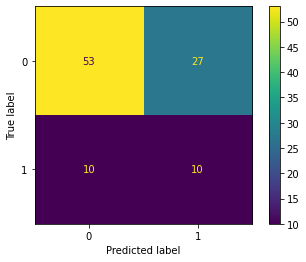

In [32]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred))
cm_display.plot();

In [33]:
import lightgbm as lgb

params = {
    'boosting_type': 'rf',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 10,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'random_state': 42,
    'path_smooth': 2
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(x_train_over, y_train_over)

y_pred = lgb_clf.predict(x_test)

print(classification_report(y_pred, y_test))

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_col_wise=true` to remove the overhead.
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        67
           1       0.40     

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [34]:
from sklearn import tree
dt_clf = tree.DecisionTreeClassifier()
dt_clf.fit(x_train_over, y_train_over)

y_pred = dt_clf.predict(x_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75        74
           1       0.20      0.15      0.17        26

    accuracy                           0.62       100
   macro avg       0.46      0.47      0.46       100
weighted avg       0.59      0.62      0.60       100



C:\Users\User\AppData\Local\Temp/ipykernel_1592/3956096115.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(x_train_over, y_train_over)


              precision    recall  f1-score   support

           0       0.60      0.83      0.70        58
           1       0.50      0.24      0.32        42

    accuracy                           0.58       100
   macro avg       0.55      0.53      0.51       100
weighted avg       0.56      0.58      0.54       100



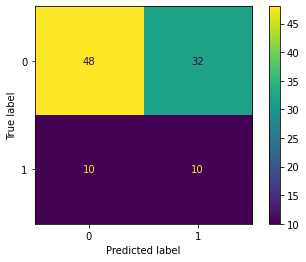

In [35]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(x_train_over, y_train_over)

y_pred = rf_clf.predict(x_test)

print(classification_report(y_pred, y_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred))
cm_display.plot();

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.97      0.80      0.88        98
           1       0.00      0.00      0.00         2

    accuracy                           0.78       100
   macro avg       0.49      0.40      0.44       100
weighted avg       0.96      0.78      0.86       100



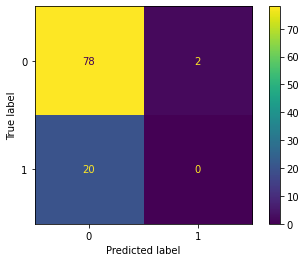

In [36]:
from sklearn.ensemble import StackingClassifier

estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
              ('lgs', LogisticRegression(max_iter=1000, C=1))              
             ]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=1000))
stacking_clf.fit(x_train_over, y_train_over)

y_pred = stacking_clf.predict(x_test)
print(classification_report(y_pred, y_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred))
cm_display.plot();

In [37]:
test_text = second_test['txt']

test_text_vec = []
for sentence in test_text:
    sentence_vec = []
    
    for word in sentence[:200]:
        sentence_vec.append(w2v_model[word])
    test_text_vec.append(np.mean(sentence_vec, axis=0))
test_text_vec = np.array(test_text_vec)

test_txt_len = np.expand_dims(second_test['txt_len'].values, axis=1)

test_vec = np.concatenate((test_text_vec, test_txt_len), axis=1)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Iteration 0 - Error: 0.4294
Iteration 1 - Error: 0.4541
Iteration 2 - Error: 0.4683
Iteration 3 - Error: 0.4688
Iteration 4 - Error: 0.4639
Iteration 5 - Error: 0.4624
Iteration 6 - Error: 0.4656
Iteration 7 - Error: 0.4706
Iteration 8 - Error: 0.4750
Iteration 9 - Error: 0.4773
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        74
           1       0.20      0.15      0.17        26

    accuracy                           0.62       100
   macro avg       0.46      0.47      0.46       100
weighted avg       0.59      0.62      0.60       100



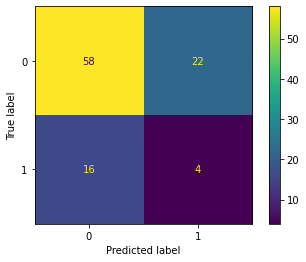

In [38]:
from sklearn.linear_model import RidgeClassifier
from adapt.instance_based import TrAdaBoost

model = TrAdaBoost(RidgeClassifier(), n_estimators=10, Xt=x_train, yt=y_train, random_state=0)
model.fit(x_train_set_1, y_train_set_1)

y_pred = model.predict(x_test)
print(classification_report(y_pred, y_test))

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred))
cm_display.plot();

In [39]:
second_pred = clf.predict(test_vec)

In [40]:
second_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,

In [41]:
first_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,

In [42]:
df = pd.DataFrame(list(first_pred) + list(second_pred), columns = ['Predicted'])

In [43]:
df

,Predicted
0,0
1,0
2,0
3,0
4,0
...,...
995,0
996,0
997,0
998,0


In [44]:
df.to_csv('out.csv')